In [1]:
!pip install yfinance
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


# Simulate Buying and Selling of Stocks

In [2]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

# Read Data 

In [3]:
tickerSymbol = 'AAPL'
data = yf.Ticker(tickerSymbol)

In [4]:
prices = data.history(start='2022-01-01', end='2022-07-01').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

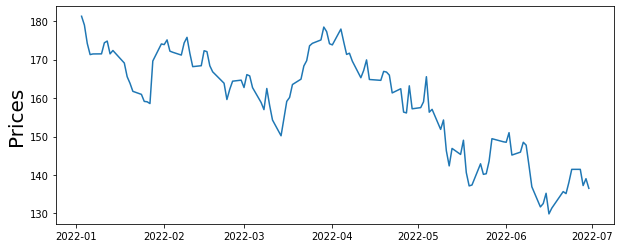

In [5]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

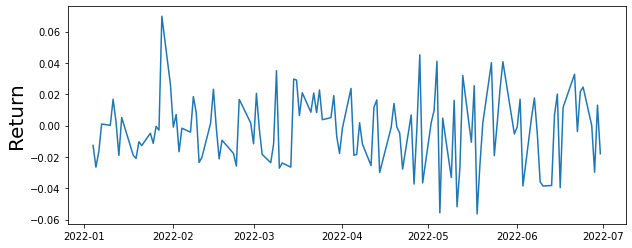

In [6]:
# We check returns graph in order to obtain a stationary time series 
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

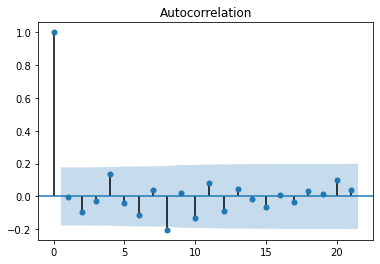

In [7]:
# We have a spike at 8 in our ACF graph which is quite impactful and hence we will have a MA(8) model 
plot_acf(returns)
plt.show()

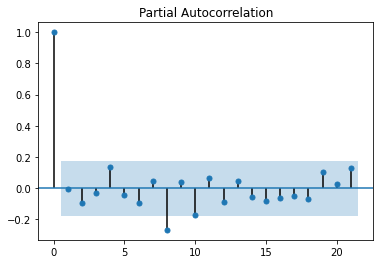

In [8]:
# In PACF also we have a spike at 8 and hence we will have an AR(8) model. Now the spikes at 8 means simply that when the markets resume after a weekend
# Hence we have spikes correlation for every monday. 
plot_pacf(returns)
plt.show()

100%|██████████| 109/109 [00:00<00:00, 6788.71it/s]


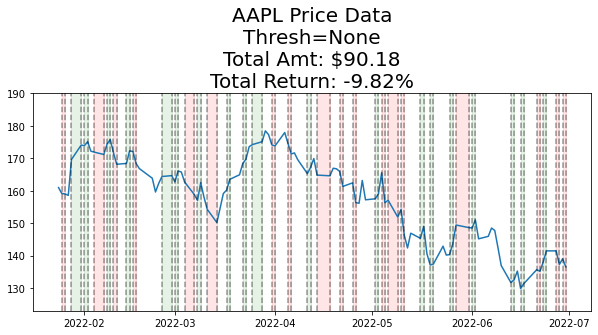

90.1763060055271

In [9]:
# From ACF graph we can say that Moving Average Model should be of the order
# of 1 and the AR model should be of the order of 8 
# But lets have some baseline models first 

# this is a completely random model where we randomly buy the stocks and sell it on other day no matter what the situation is. Hence we just keep randomly
# buying stocks. In order to obtain a clear picture we must do many iterations of random buying in order to understand how our model behaves for random 
# buying and selling of stocks. 
run_simulation(returns, prices, 100, 0.5, None, verbose=False)


In [10]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|██████████| 109/109 [00:00<00:00, 5403.69it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Avg: $96.51\nSD: $10.73')

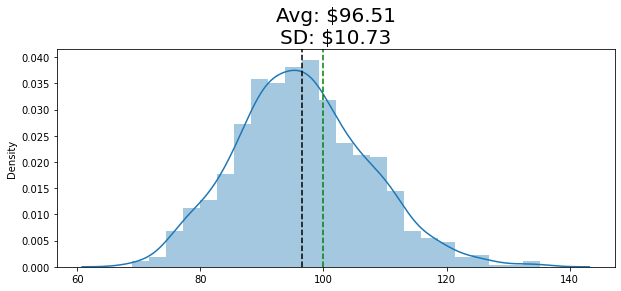

In [11]:
# So on an average we will loose money if we buy the stock randomly 
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

100%|██████████| 109/109 [00:00<00:00, 2572.16it/s]


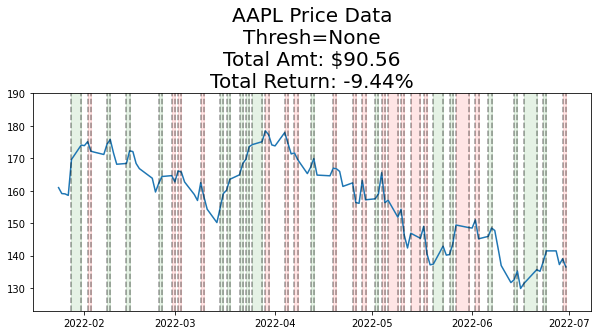

90.55646748217745

In [12]:
# Now lets say we buy the stock if the last return was positive 
run_simulation(returns, prices, 100, 'last', None, verbose=False)

100%|██████████| 109/109 [00:04<00:00, 23.19it/s]


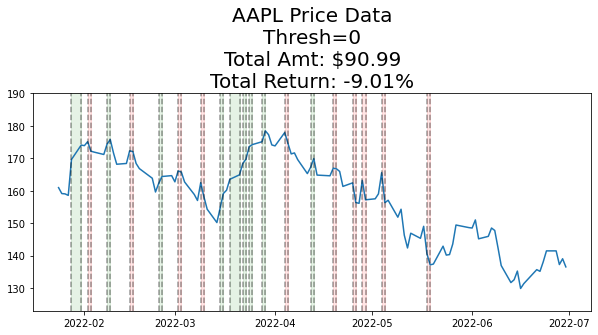

100%|██████████| 109/109 [00:04<00:00, 25.66it/s]


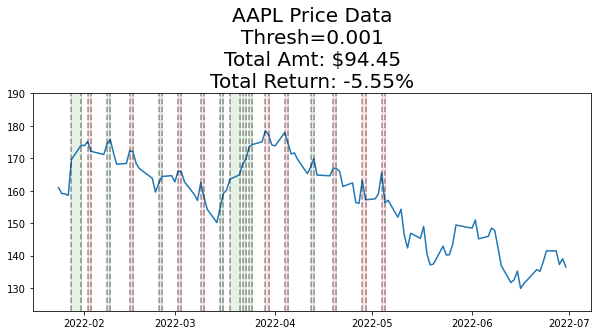

100%|██████████| 109/109 [00:04<00:00, 23.54it/s]


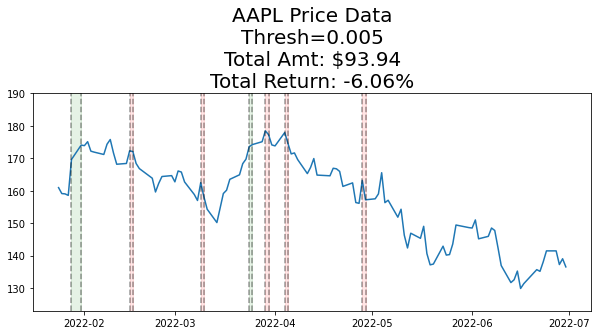

In [13]:
# Lets try AR(1) model for different threshold values 
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=False)

  0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
100%|██████████| 109/109 [04:36<00:00,  2.54s/it]


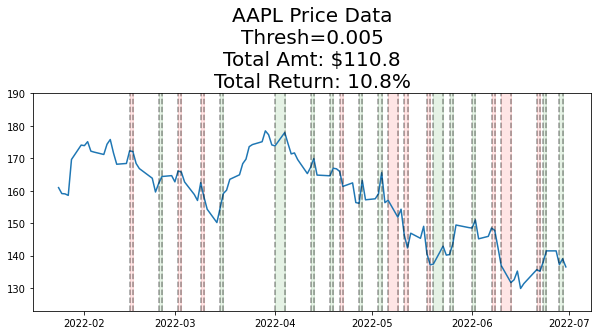

110.79846171267695

In [14]:
# Lets try AR (8) model 
run_simulation(returns, prices, 100, (8,0,0), thresh, verbose=False)

In [ ]:
# Lets try with ARMA(8,8)

run_simulation(returns, prices, 100, (8,0,8), thresh, verbose=False)

  6%|▌         | 6/109 [00:07<02:16,  1.32s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:726: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:728: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_numdiff.py:470: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/